![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1


In [4]:
bikes = bikes.reset_index(drop=True)
# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [5]:
bikes.shape

(10886, 12)

### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

El valor promedio de bicicletas alquiladas en primera, verano y otoño es mayor que en invierno. Como es de esperarse, en invierno no se alquila el mismo número de bicicletas por las condiciones climáticas que hacen más difícil el uso de este medio de transporte.

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [8]:
bikes.hour.describe()

count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

Por otra parte, la mayor proporción de bicicletas alquiladas está entre las 7am y 8pm. Nuevamente, confirma las hipótesis porque en esta franja de tiempo seguramente hay más personas en las calles, teniendo en cuenta que incluye horarios laborales. En horas de la noche, es más probable que la mayoría dde personas esté en su casa.

En la matriz a continuación, se puede apreciar la correlación entre las variables. La temperatura normalizada (temp) y la sesación de temperatura (atemp) están altamente correlacionadas porque se refieren a la misma variable general.

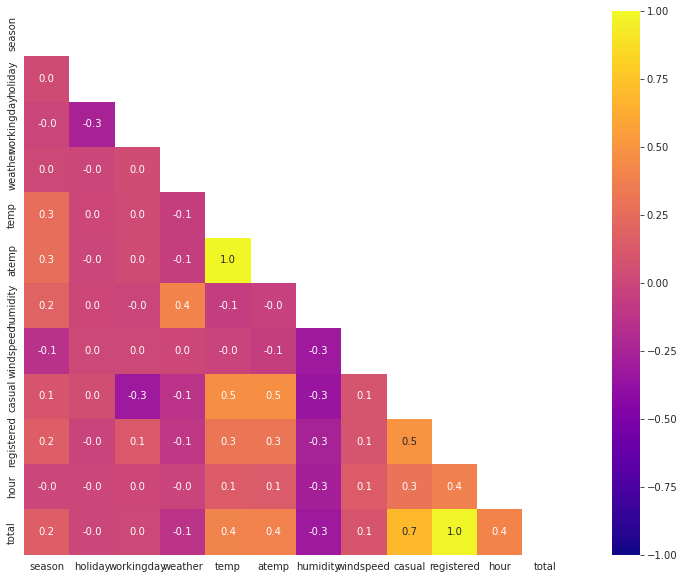

In [9]:
import seaborn as sns

# Organizando columnas para la presentación de la matriz
tmp = bikes.copy()
total = bikes.total
del tmp['total']
tmp['total'] = total

# Plotting
corr = tmp.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, cmap='plasma', annot=True, fmt='.1f')

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

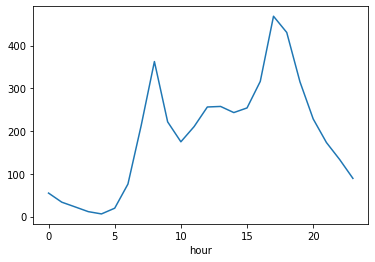

In [10]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

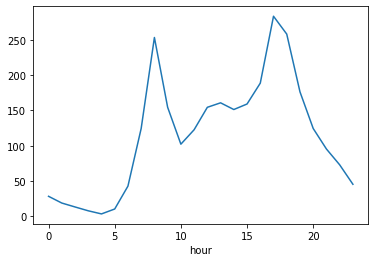

In [11]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

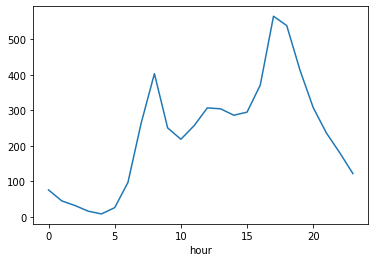

In [12]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot()

Ahora, analizando las gráficas anteriores se puede confirmar que el número de bicicletas alquiladas en invierno (Celda 2.2) es significativamente más bajo que en verano (Celda 2.3) por la condición climática pues es de esperar que las  personas prefieran hacer uso de otro medio de transporte. Asimismo, se puede afirmar que en general, durante las 7am y 8pm se alquila el mayor número de bicicletas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta, "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [13]:
bikes.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
total           int64
hour            int64
dtype: object

In [14]:
# Celda 3
X = bikes[["season","hour"]]
y = bikes["total"]

# Dropping any rows with Nan values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25)
  
# Splitting the data into training and testing data
linearRegression = LinearRegression()  
linearRegression.fit(Xtrain, ytrain)

# Imprimir intercepto y coeficientes
print("Intercepto: ", linearRegression.intercept_)
pd.DataFrame(zip(X.columns, linearRegression.coef_))

Intercepto:  2.6558247885014055


,0,1
0,season,26.592387
1,hour,10.544697


In [15]:
# Predicciones
ypred = linearRegression.predict(Xtest)

# Calcular el error cuadrático medio (MSE) y r2
linearRegressionMSE = mean_squared_error(ytest, ypred)
linearRegressionR2 = r2_score(ytest, ypred)

# Imprimir Score y MSE
print("Score: ", linearRegression.score(Xtest, ytest))
print("MSE: ", linearRegressionMSE)
print("R2: ", linearRegressionR2)

Score:  0.195240682949831
MSE:  25609.985108679983
R2:  0.195240682949831


In [16]:
bikes["season"].unique()

array([1, 2, 3, 4], dtype=int64)

#### Interpretación de coeficientes
* **Intercepto**: El valor promedio de bicicletas alquiladas por hora cada día es igual a 2.66.
* **Season**: Por un incremento unitario en la estación (1:winter, 2:spring, 3:summer, 4:fall), la cantidad total de bicicletas incrementa en promedio 26.59. Hay menos bicicletas alquiladas en invierno y más es otoño. Aunque se trata de una variable categórica, seguramente el número de bicicletas alquiadas es menor en invierno season = 1.
* **Hour**: Por un incremento unitario en la hora, la cantidad total de bicicletas incrementa en promedio 10.54.


#### Limitación Regresión Lineal
En este caso, la regresión lineal está limitada porque la variable predictora 'season' es categórica y aunque puede ser una  variable dummie, el modelo considera un número y asimismo se interpreta (como un vector). Además supone una relación lineal  entre las variables.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [17]:
# Celda 4
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [18]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [19]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean())
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [20]:
decisionTreeManual = tree_grow(Xtrain, ytrain, level=0, min_gain=0.001, max_depth=8, num_pct=10)

In [21]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [22]:
# Predicciones
ypred = tree_predict(Xtest, decisionTreeManual)

# Calcular el error cuadrático medio (MSE) y R2
decisionTreeManualMSE = mean_squared_error(ytest, ypred)
decisionTreeManualR2 = r2_score(ytest, ypred)

# Imprimir Score y MSE
print("MSE: ", decisionTreeManualMSE)
print("R2: ", decisionTreeManualR2)

MSE:  12715.590374724467
R2:  0.6004296846551191


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [23]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 11)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
r2scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    decisionTree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    r2scores.append(cross_val_score(decisionTree, Xtrain, ytrain, cv=10, scoring='r2').mean())

Text(0, 0.5, 'R2')

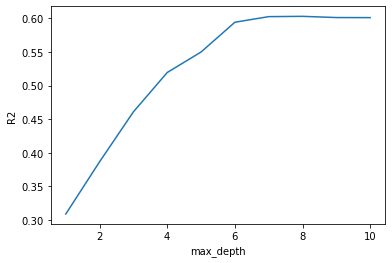

In [24]:
%matplotlib inline

# Gráfica max_depth versus R2 (error del modelo)
plt.plot(max_depth_range, r2scores)
plt.xlabel('max_depth')
plt.ylabel('R2')

In [25]:
# Mejor R2 (desempeño del modelo) y su correspondiente max_depth
sorted(zip(r2scores, max_depth_range))[::-1][0]

(0.6029988387948817, 8)

In [26]:
# Teniendo en cuenta resultados anteriores, max_depth=8 fue el mejor modelo, se ajusta un árbol usando este valor 
decisionTree = DecisionTreeRegressor(max_depth=8, random_state=1)
decisionTree.fit(Xtrain, ytrain)

DecisionTreeRegressor(max_depth=8, random_state=1)

In [27]:
export_graphviz(decisionTree, out_file ='tree.dot') 

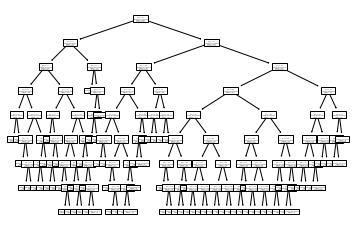

In [28]:
tree.plot_tree(decisionTree);

In [29]:
# Predicciones
ypred = decisionTree.predict(Xtest)

# Calcular el error cuadrático medio (MSE) y R2
decisionTreeMSE = mean_squared_error(ytest, ypred)
decisionTreeR2 = r2_score(ytest, ypred)

# Imprimir Score y MSE
print("MSE: ", decisionTreeMSE)
print("R2: ", decisionTreeR2)

MSE:  12711.604744976394
R2:  0.6005549277062362


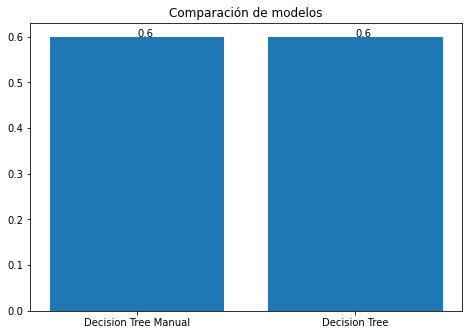

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Decision Tree Manual', 'Decision Tree']
ejeY = [round(decisionTreeManualR2,2),round(decisionTreeR2,2)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

El árbol de decisión manual y con librería presenta valores cercanos de R2. Para este ejercicio y esperando que los modelos sean comparables, los dos modelos se corren con el mismo número para max_depth = 8.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [31]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [32]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [33]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [34]:
# Celda 6

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 11)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    decisionTreeClf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(decisionTreeClf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

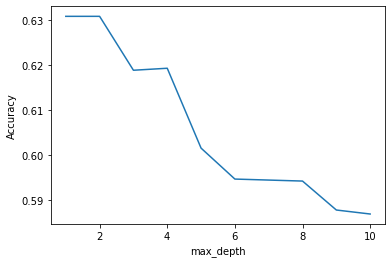

In [35]:
%matplotlib inline
# Gráfica max_depth versus accuracy (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [36]:
# Mejor R2 (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [37]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
decisionTreeClf = DecisionTreeClassifier(max_depth=2, random_state=1)
decisionTreeClf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

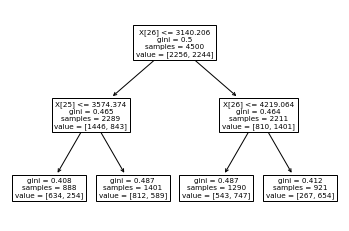

In [38]:
tree.plot_tree(decisionTreeClf);

In [39]:
# Predicciones
ypred = decisionTree.predict(Xtest)

# Calcular el error cuadrático medio (MSE) y R2
decisionTreeMSE = mean_squared_error(ytest, ypred)
decisionTreeR2 = r2_score(ytest, ypred)

# Imprimir Score y MSE
print("MSE: ", decisionTreeMSE)
print("R2: ", decisionTreeR2)

MSE:  12711.604744976394
R2:  0.6005549277062362


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [40]:
X_train.shape

(4500, 59)

#### 100 árboles de decisión donde max_depth tome un valor de su elección

In [41]:
# Celda 7

# Uso de BaggingClassifier de la libreria (sklearn) donde se usa el modelo DecisionTreeClassifier como estimador
from sklearn.ensemble import BaggingClassifier
baggingClassifierDepth = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, bootstrap=True,
                           max_samples = 300, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
baggingClassifierDepth.fit(X_train, y_train)
ypred = baggingClassifierDepth.predict(X_test)

# Métricas de desempeño
baggingClassifierDepthF1 = metrics.f1_score(ypred, y_test)
baggingClassifierDepthAccuracy = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", baggingClassifierDepthF1)
print("Accuracy: ", baggingClassifierDepthAccuracy)

F1 Score:  0.649932157394844
Accuracy:  0.656


#### 100 árboles de decisión donde min_samples_leaf tome un valor de su elección

In [42]:
# Uso de BaggingClassifier de la libreria (sklearn) donde se usa el modelo DecisionTreeClassifier como estimador
baggingClassifierLeaf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1), n_estimators=100,
                                          max_samples = 300, bootstrap=True, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
baggingClassifierLeaf.fit(X_train, y_train)
ypred = baggingClassifierLeaf.predict(X_test)

# Métricas de desempeño
baggingClassifierLeafF1 = metrics.f1_score(ypred, y_test)
baggingClassifierLeafAccuracy = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", baggingClassifierLeafF1)
print("Accuracy: ", baggingClassifierLeafAccuracy)

F1 Score:  0.6626262626262627
Accuracy:  0.666


#### 100 regresiones logísticas

In [43]:
from sklearn.linear_model import LogisticRegression
# Uso de BaggingClassifier de la libreria (sklearn) donde se usa el modelo DecisionTreeClassifier como estimador
baggingClassifierLR = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, max_samples = 300,
                                          bootstrap=True, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
baggingClassifierLR.fit(X_train, y_train)
ypred = baggingClassifierLR.predict(X_test)

# Métricas de desempeño
baggingClassifierLRF1 = metrics.f1_score(ypred, y_test)
baggingClassifierLRAccuracy = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", baggingClassifierLRF1)
print("Accuracy: ", baggingClassifierLRAccuracy)

F1 Score:  0.6088737201365187
Accuracy:  0.618


### Ensamble Votación Mayoritaria

In [44]:
from sklearn.ensemble import VotingClassifier
# Crear clasificador por votación
votingClf = VotingClassifier(estimators=[('dtDepth', baggingClassifierDepth), ('dtLeaf', baggingClassifierLeaf),
                                          ('lr', baggingClassifierLR)], voting='hard')

# Entrenar clasificador por votación
votingClf.fit(X_train, y_train)

# Predicción en el set test
ypred = votingClf.predict(X_test)

# Métricas de desempeño
votingClfF1 = metrics.f1_score(ypred, y_test)
votingClfAccuracy = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", votingClfF1)
print("Accuracy: ", votingClfAccuracy)

F1 Score:  0.6540284360189573
Accuracy:  0.6593333333333333


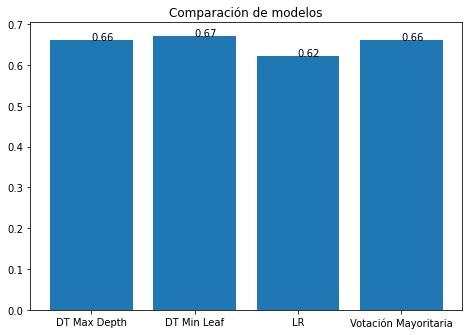

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['DT Max Depth', 'DT Min Leaf','LR', 'Votación Mayoritaria']
ejeY = [round(baggingClassifierDepthAccuracy,2),round(baggingClassifierLeafAccuracy,2),
        round(baggingClassifierLRAccuracy,2),round(votingClfAccuracy,2)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

En este caso los modelos tienen valores para accuracy similares, el árbol de decisión y el ensamble de votació mayoritaria presenta valores muy cercanos.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

#### 100 árboles de decisión donde max_depth tome un valor de su elección

In [46]:
# Celda 8

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(baggingClassifierDepth.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], baggingClassifierDepth.n_estimators))

for i in range(baggingClassifierDepth.n_estimators):
    oob_sample = ~baggingClassifierDepth.estimators_samples_[i]
    y_pred_ = baggingClassifierDepth.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = baggingClassifierDepth.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
ypred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Métricas de desempeño
baggingClassifierDepthF1New = metrics.f1_score(ypred, y_test)
baggingClassifierDepthAccuracyNew = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", baggingClassifierDepthF1New)
print("Accuracy: ", baggingClassifierDepthAccuracyNew)

F1 Score:  0.6342141863699582
Accuracy:  0.6493333333333333


#### 100 árboles de decisión donde min_samples_leaf tome un valor de su elección

In [47]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(baggingClassifierLeaf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], baggingClassifierLeaf.n_estimators))

for i in range(baggingClassifierLeaf.n_estimators):
    oob_sample = ~baggingClassifierLeaf.estimators_samples_[i]
    y_pred_ = baggingClassifierLeaf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = baggingClassifierLeaf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
ypred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Métricas de desempeño
baggingClassifierLeafF1New = metrics.f1_score(ypred, y_test)
baggingClassifierLeafAccuracyNew = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", baggingClassifierLeafF1New)
print("Accuracy: ", baggingClassifierLeafAccuracyNew)

F1 Score:  0.6640053226879573
Accuracy:  0.6633333333333333


#### 100 regresiones logísticas

In [48]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(baggingClassifierLR.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], baggingClassifierLR.n_estimators))

for i in range(baggingClassifierLR.n_estimators):
    oob_sample = ~baggingClassifierLR.estimators_samples_[i]
    y_pred_ = baggingClassifierLR.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = baggingClassifierLR.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
ypred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Métricas de desempeño
baggingClassifierLRF1New = metrics.f1_score(ypred, y_test)
baggingClassifierLRAccuracyNew = metrics.accuracy_score(ypred, y_test)

# Imprimir F1 Score y Accuracy
print("F1 Score: ", baggingClassifierLRF1New)
print("Accuracy: ", baggingClassifierLRAccuracyNew)

F1 Score:  0.6117166212534061
Accuracy:  0.62


### Ensamble Votación Ponderada

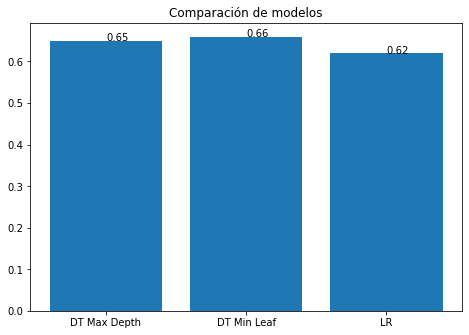

In [49]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['DT Max Depth', 'DT Min Leaf','LR']
ejeY = [round(baggingClassifierDepthAccuracyNew,2),round(baggingClassifierLeafAccuracyNew,2),
        round(baggingClassifierLRAccuracyNew,2)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### Celda 9

Considerando los resultados obtenidos con los modelos propuestos, no se evidencian diferencias significativas para F1 Score y Accuracy pues en general son muy similares (excepto para la regresión logística que tiene un desempeño claramente más bajo). Para todos los modelos, tanto accuracy como F1 score son mayores a 0.6. En este caso, seguramente se debe evaluar selección de variables y otras técnicas de machine learning que permitan mejorar las predicciones.

De igual manera, el ensamble por votación mayoritaria y ponderada arroja desempeños muy similares. Esto se puede presentar porque el ensamble estuvo compuesto por 300 muestras bagged y 100 modelos distintos.

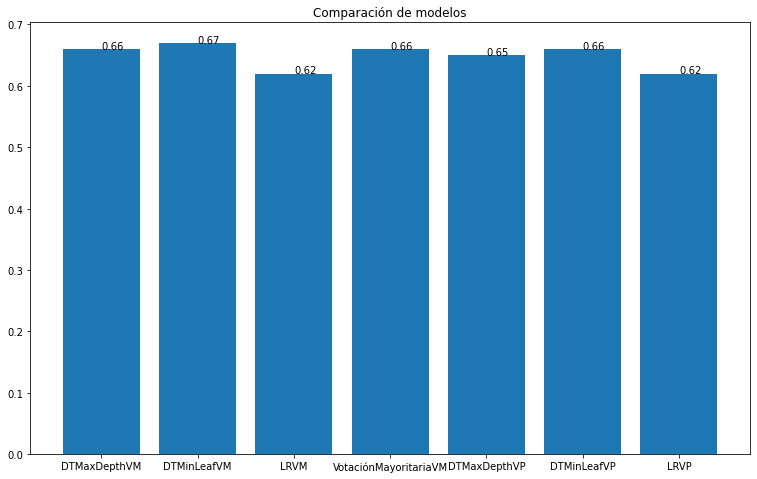

In [50]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['DTMaxDepthVM', 'DTMinLeafVM','LRVM', 'VotaciónMayoritariaVM', 'DTMaxDepthVP', 'DTMinLeafVP','LRVP']
ejeY = [round(baggingClassifierDepthAccuracy,2),round(baggingClassifierLeafAccuracy,2),round(baggingClassifierLRAccuracy,2),
        round(votingClfAccuracy,2), round(baggingClassifierDepthAccuracyNew,2),round(baggingClassifierLeafAccuracyNew,2),
        round(baggingClassifierLRAccuracyNew,2)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()